In [21]:
import pickle
import pandas as pd

from data.data import AmericanStories
from bertopic import BERTopic
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

In [22]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v1", model_kwargs={"torch_dtype": "float16"})

In [23]:
loaded_model = BERTopic.load("models/full_model_15", embedding_model=embedding_model)

In [24]:
years = [1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819]

In [25]:
ds_american = AmericanStories().dataset.filter(lambda example: example["Year"] in years and len(example["CleanedText"])>100) 

ds_american = ds_american.filter(lambda example: 'political' in example["newspaper_name"])

Filter:   0%|          | 0/598880 [00:00<?, ? examples/s]

In [26]:
print(len(ds_american))

134224


In [27]:
ds_american[190]

{'article_id': '13_1808-09-02_p4_sn84024013_00414216080_1808090201_0318',
 'newspaper_name': 'Alexandria daily gazette, commercial &amp; political. [volume] (Alexandria [Va.]) 1808-1812',
 'edition': '01',
 'date': '1808-09-02',
 'page': 'p4',
 'headline': '',
 'byline': '',
 'Text': "Jofeph Mande VII\ncoRNkR Of KING and fxIRFlx s,b,s\n\n\nALkxANERIA\n\n\nHAS FOR SALE,\nAn anortnent Of Wines\nQUoRs, GROCERIES, Sc\nConsisting of\n\n\n!: !: ]: !. '''.'\n\n\nMADE1RA1\n\n\nPort\n\n\nLisbon WINES.\nMalaga B\n\n\nTeneriae <\n\n\nCorsica\n\n\nCid st. Estephe Medee larct, in cases\none dozen\n\n\nA few dezen fine old frontinac\nDitto do. best wine bitters\nJamaica and West-India rum\nNew-England do.\nCogiliae, Bourdeaux and Naples brand,\n& Holland and country gin\nSchiedam ginin cases\nIrish whIskey, very Old\n70 barrels Pennsylvania rye sxey\nCIDER in barrels\n\n\nWhite wine and Cider vinegar\nFlorence oi. in TASKS\n2 hogsheads HAVANA honey\nIs do. choice retailing mchssm\n\n\nGunpowder\n\n\

In [28]:
pd.Series(ds_american["newspaper_name"]).value_counts().sort_index()

Alexandria daily gazette, commercial &amp; political. [volume] (Alexandria [Va.]) 1808-1812    59184
Alexandria gazette, commercial and political. [volume] (Alexandria [Va.]) 1812-1817            75040
Name: count, dtype: int64

<Axes: >

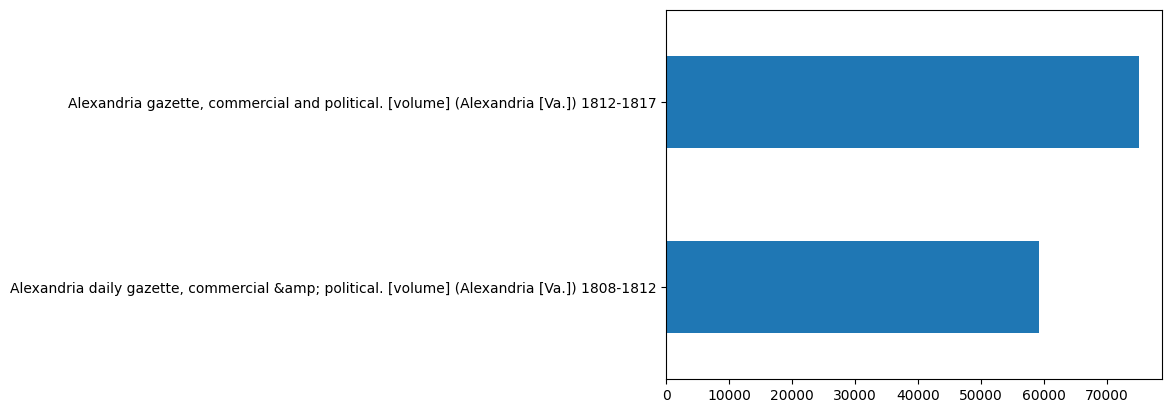

In [29]:
pd.Series(ds_american["newspaper_name"]).value_counts().sort_index().plot(kind="barh")

In [30]:
american_embeddings = embedding_model.encode(ds_american["CleanedText"], show_progress_bar=True)
with open("dataset_embeds_distiluse-base-multilingual-cased-v1/american_embeds.pkl", 'wb') as p:
    pickle.dump(american_embeddings, p)

Batches:   0%|          | 0/4195 [00:00<?, ?it/s]

In [31]:
with open("dataset_embeds_distiluse-base-multilingual-cased-v1/american_embeds.pkl", 'rb') as p:
    american_embeddings = pickle.load(p)

In [32]:
american_topics, american_probs = loaded_model.transform(documents=ds_american['CleanedText'], embeddings=american_embeddings)

2025-09-05 16:48:29,823 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [33]:
american_topic_freq = dict(Counter(american_topics).most_common())

In [34]:
american_topic_freq

{np.int64(3): 10190,
 np.int64(86): 8172,
 np.int64(36): 7349,
 np.int64(29): 7276,
 np.int64(75): 6135,
 np.int64(73): 5768,
 np.int64(82): 4934,
 np.int64(2): 4573,
 np.int64(45): 4539,
 np.int64(39): 4418,
 np.int64(78): 3563,
 np.int64(52): 3354,
 np.int64(24): 3020,
 np.int64(31): 2562,
 np.int64(8): 2458,
 np.int64(27): 2425,
 np.int64(67): 2421,
 np.int64(18): 2297,
 np.int64(13): 2251,
 np.int64(4): 2053,
 np.int64(48): 2040,
 np.int64(20): 2032,
 np.int64(14): 1910,
 np.int64(7): 1731,
 np.int64(70): 1637,
 np.int64(10): 1535,
 np.int64(9): 1517,
 np.int64(77): 1517,
 np.int64(6): 1487,
 np.int64(-1): 1361,
 np.int64(62): 1360,
 np.int64(72): 1340,
 np.int64(33): 1278,
 np.int64(64): 1164,
 np.int64(34): 1155,
 np.int64(21): 1047,
 np.int64(40): 960,
 np.int64(61): 863,
 np.int64(63): 857,
 np.int64(57): 828,
 np.int64(90): 821,
 np.int64(28): 814,
 np.int64(22): 793,
 np.int64(26): 789,
 np.int64(80): 736,
 np.int64(30): 716,
 np.int64(71): 709,
 np.int64(12): 646,
 np.int64(

In [40]:
loaded_model.get_topic_info(45)

,Topic,Count,Name,Representation,Representative_Docs
0,45,29,45_drukkerij_boeken staten_gouverneur generaal...,"[drukkerij, boeken staten, gouverneur generaal...",NaN


In [41]:
df_topics_american = pd.DataFrame({"topic":american_topics, "text":ds_american["CleanedText"], "year":ds_american["Year"], "ds": 'american'})

In [45]:
def plot_yearly_topic(topic, df_topics, show_all=True):
    all_counts = df_topics["year"].value_counts().sort_index().to_frame().reset_index()
    topic_counts = df_topics[df_topics["topic"]==topic]["year"].value_counts().sort_index().to_frame().reset_index()
    if show_all:
        plt.bar(all_counts["year"]-0.2, all_counts["count"], 0.4)
        plt.bar(topic_counts["year"]+0.2, topic_counts["count"], 0.4)
        plt.legend(["All", f"Topic {topic} mentions"])
    else:
        plt.bar(topic_counts['year'], topic_counts['count'])
        plt.legend([f"{topic} mentions"])
    plt.grid()

In [43]:
def plot_topics(topics, df_topics, title):
    df = df_topics[["year", "topic"]]
    df = df[df['topic'].isin(topics)]
    df.groupby(["year", "topic"]).value_counts().unstack().plot.barh()
    plt.title(title)
    plt.show()

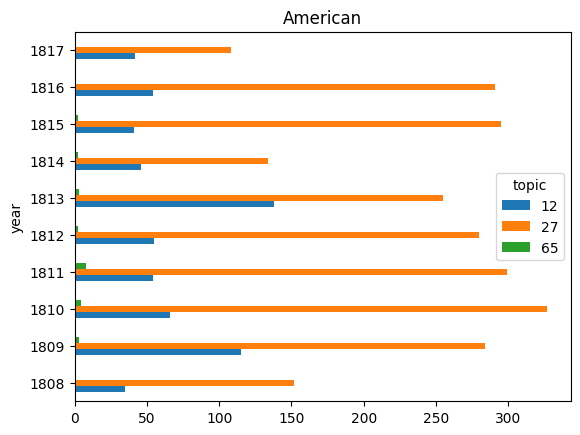

In [44]:
plot_topics([12, 27, 65], df_topics_american, 'American')

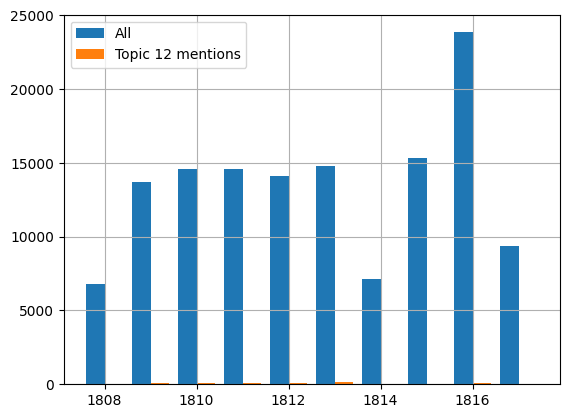

In [46]:
plot_yearly_topic(12, df_topics_american, show_all=True)